In [1]:
import getpass
import os
from langchain_core.prompts import ChatPromptTemplate
from langchain_experimental.tools import PythonAstREPLTool
from langchain.output_parsers.openai_tools import JsonOutputKeyToolsParser
import pandas as pd
from io import StringIO


# os.environ["OPENAI_API_KEY"] = getpass.getpass('Password: ')
api_key = "sk-pzmVDXe1-rxgtV34fEob57Owp9b7Z7_k-jYKmFaguDT3BlbkFJXR835WsPGSV7P_sjJXS2QGOJBIxgW5wSzwqExklvAA"

from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", api_key=api_key)

TODO: give user permission to name files

In [70]:
def create_multiple_file_chain_info_version(csv_file_path_list, LLM_model):
    df_dict = {}
    df_info_list = []
    buffer = StringIO()
    cur = 1
    for file_path in csv_file_path_list:
        df = pd.read_csv(file_path, delimiter=',')
        file_name = file_path.split('/')[-1]
        print(f"Read the file {file_name}!")
        df.info(buf=buffer)
        df_name = f"df_{cur}"
        cur += 1
        df_info_list.append((df_name, buffer.getvalue()))
        buffer.flush()
        df_dict[df_name] = df.copy()
        print(f"{df_name} : {file_path}")
    df_template = """```python
    {df_name}.info()
    >>> {df_info}
    ```"""
    df_context = "\n\n".join(
        df_template.format(df_name=df_name, df_info=df_info)
        for df_name, df_info in df_info_list
    )
    tool = PythonAstREPLTool(locals=df_dict)
    llm_with_tools = LLM_model.bind_tools([tool], tool_choice=tool.name)
    parser = JsonOutputKeyToolsParser(key_name=tool.name, first_tool_only=True)
    system = f"""You have access to a number of pandas dataframes. \
    Here is the info from each dataframe`:
    {df_context}
    Given a user question about the dataframes, write the Python code to answer it. \
    Return ONLY the valid Python code and nothing else. \
    Don't assume you have access to any libraries other than built-in Python ones, pandas and matplotlib. \
    Ensure that there is not index error when referring to a column name. \
    Always ENSURE that the code return a pandas Dataframe.
    Please CHECKT column name for each dataframe carefully.
    """
    prompt = ChatPromptTemplate.from_messages([("system", system), ("human", "{question}")])
    chain = (prompt | llm_with_tools | parser | tool)  # noqa
    return chain


def create_multiple_file_chain_info_version_3(csv_file_path_list, LLM_model):
        df_dict = {}
        df_info_list = []
        buffer = StringIO()
        cur = 1
        for file_path in csv_file_path_list:
            df = pd.read_csv(file_path, delimiter=',')
            file_name = file_path.split('/')[-1]
            print(f"Read the file {file_name}!")
            df.info(buf=buffer)
            info_lines = buffer.getvalue().splitlines()
            trimmed_info = '\n'.join(info_lines[1:-2])
            df_name = f"csv_{cur}"
            cur += 1
            df_info_list.append((df_name, trimmed_info, file_path))
            buffer.truncate(0)
            buffer.seek(0)
            df_dict[df_name] = df.copy()
            print(f"{df_name} : {file_path}")

        df_template = """```
        {df_name}.info()
        File Path of {df_name}: {file_path}
        >>> {df_info}
        ```"""

        df_context = "\n\n".join(
            df_template.format(df_name=df_name, df_info=df_info,
                            file_path=file_path)
            for df_name, df_info, file_path in df_info_list
        )

        tool = PythonAstREPLTool(locals=df_dict)
        llm_with_tools = LLM_model.bind_tools([tool], tool_choice=tool.name)
        parser = JsonOutputKeyToolsParser(key_name=tool.name, first_tool_only=True)

        # Modify the system message with clearer instructions if necessary
        system = f"""You have access to several pandas DataFrames. The following information contains the structure (column names and types) for each DataFrame:
        {df_context}

        Based on a user's request about the data, generate Python code that uses only built-in Python libraries, pandas, and matplotlib. The code must be valid, complete, and functional.

        Here are the key requirements:
        1. Include all necessary import statements at the beginning of the code.
        2. Ensure the code handles potential column name or index errors by carefully checking the DataFrame's structure.
        3. Apply any necessary data preprocessing steps to handle missing data, incorrect data types, or any other common issues that could arise in the data. Pay special attention to ensuring that the data types are correct and consistent across columns to avoid type-related errors. Unify the data type if necessary
        4. Ensure the intermediate state dataframe is stored in memory, if necessary, for future processing steps.
        5. The output of the code must always be a pandas(pd) DataFrame.
        6. Return only the Python code—no explanations, comments, or extra text."""

        prompt = ChatPromptTemplate.from_messages(
            [("system", system), ("human", "#依頼\n{question}")])

        chain = (prompt | llm_with_tools | parser | tool)  # noqa
        return chain


## more experiments on complex operations
Here we will experiment on possible operations one by one

In [3]:
file_path_1 = '0924_テスト用データ(9月分)/INPUTデータ(9月)/納品物作成/2_yonosuke/①今月給与明細データ.csv'
file_path_2 = '0924_テスト用データ(9月分)/INPUTデータ(9月)/納品物作成/2_yonosuke/③9月賞与データ.csv'

multiple_file_chain = create_multiple_file_chain_info_version([file_path_1, file_path_2], llm)

Read the file ①今月給与明細データ.csv!
df_1 : 0924_テスト用データ(9月分)/INPUTデータ(9月)/納品物作成/2_yonosuke/①今月給与明細データ.csv
Read the file ③9月賞与データ.csv!
df_2 : 0924_テスト用データ(9月分)/INPUTデータ(9月)/納品物作成/2_yonosuke/③9月賞与データ.csv


### Prompt in English and Japanese

Assume there is a agent that can give code on pandas.
Write a prompt to tell the agent to

#### basic operations

filter rows: df['column'] > val

In [7]:
prompt = "Please filter 'df_1' to include all the rows where the value in the column '基本給' is greater than 180,000."
multiple_file_chain.invoke(prompt)

,従業員名,スタッフコード,基本給,基本給調整,非課税通勤手当,課税通勤手当,通勤費調整（非）,通勤費調整（課）,自宅駐車場手当,自宅駐車場手当調整,...,所定内残業,普通残業,深夜残業,法定外休日残業,法定休日残業,60時間超,代休控除日数,遅刻早退欠勤控除時間,当月所定労働時間,備考
0,テスト 名483187,483187,599037,0,7100,1200,0,0,0,0,...,0:00,4:52,0:00,0:00,0:00,0:00,0.0,0:00,0:00,NaN
1,テスト 名489280,489280,240051,0,0,0,0,0,0,0,...,7:30,15:15,0:00,7:00,0:00,0:00,0.0,0:00,147:00,NaN
2,テスト 名489285,489285,216825,0,3600,0,0,0,0,0,...,7:30,6:30,0:00,0:00,0:00,0:00,0.0,0:00,147:00,NaN
3,テスト 名489296,489296,202125,0,7100,2900,0,0,0,0,...,6:30,2:00,0:00,0:00,0:00,0:00,0.0,0:00,147:00,NaN
4,テスト 名489299,489299,198156,0,7100,1400,0,0,0,0,...,8:00,2:00,0:00,0:00,0:00,0:00,0.0,0:00,147:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,テスト 名976903,976903,320000,0,0,0,0,0,0,0,...,0:00,15:21,0:00,0:00,0:00,0:00,0.0,0:00,0:00,NaN
485,テスト 名977015,977015,512500,0,0,0,0,0,0,0,...,0:00,15:18,0:00,0:00,0:00,0:00,0.0,0:00,0:00,NaN
486,テスト 名977903,977903,520000,0,0,0,0,0,0,0,...,0:00,14:34,0:00,0:00,0:00,0:00,0.0,0:00,0:00,NaN
487,テスト 名978107,978107,460000,0,0,0,0,0,0,0,...,0:00,8:13,0:00,0:00,0:00,0:00,0.0,0:00,0:00,NaN


In [5]:
prompt = "'df_1'から、`基本給` が180,000より大きい行をフィルタリンしてください。"
multiple_file_chain.invoke(prompt)

,従業員名,スタッフコード,基本給,基本給調整,非課税通勤手当,課税通勤手当,通勤費調整（非）,通勤費調整（課）,自宅駐車場手当,自宅駐車場手当調整,...,所定内残業,普通残業,深夜残業,法定外休日残業,法定休日残業,60時間超,代休控除日数,遅刻早退欠勤控除時間,当月所定労働時間,備考
0,テスト 名483187,483187,599037,0,7100,1200,0,0,0,0,...,0:00,4:52,0:00,0:00,0:00,0:00,0.0,0:00,0:00,NaN
1,テスト 名489280,489280,240051,0,0,0,0,0,0,0,...,7:30,15:15,0:00,7:00,0:00,0:00,0.0,0:00,147:00,NaN
2,テスト 名489285,489285,216825,0,3600,0,0,0,0,0,...,7:30,6:30,0:00,0:00,0:00,0:00,0.0,0:00,147:00,NaN
3,テスト 名489296,489296,202125,0,7100,2900,0,0,0,0,...,6:30,2:00,0:00,0:00,0:00,0:00,0.0,0:00,147:00,NaN
4,テスト 名489299,489299,198156,0,7100,1400,0,0,0,0,...,8:00,2:00,0:00,0:00,0:00,0:00,0.0,0:00,147:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,テスト 名976903,976903,320000,0,0,0,0,0,0,0,...,0:00,15:21,0:00,0:00,0:00,0:00,0.0,0:00,0:00,NaN
485,テスト 名977015,977015,512500,0,0,0,0,0,0,0,...,0:00,15:18,0:00,0:00,0:00,0:00,0.0,0:00,0:00,NaN
486,テスト 名977903,977903,520000,0,0,0,0,0,0,0,...,0:00,14:34,0:00,0:00,0:00,0:00,0.0,0:00,0:00,NaN
487,テスト 名978107,978107,460000,0,0,0,0,0,0,0,...,0:00,8:13,0:00,0:00,0:00,0:00,0.0,0:00,0:00,NaN


select multiple columns

In [74]:
prompt = "Please select the columns '基本給', '基本給調整', '非課税通勤手当', and '課税通勤手当' from 'df_1'"
multiple_file_chain.invoke(prompt)

,基本給,基本給調整,非課税通勤手当,課税通勤手当
0,599037,0,7100,1200
1,240051,0,0,0
2,216825,0,3600,0
3,202125,0,7100,2900
4,198156,0,7100,1400
...,...,...,...,...
485,512500,0,0,0
486,520000,0,0,0
487,460000,0,0,0
488,126000,0,4200,1000


In [75]:
prompt = "'df_1' から、'基本給'、'基本給調整'、'非課税通勤手当'、'課税通勤手当'の列を選択してください。"
multiple_file_chain.invoke(prompt)

,基本給,基本給調整,非課税通勤手当,課税通勤手当
0,599037,0,7100,1200
1,240051,0,0,0
2,216825,0,3600,0
3,202125,0,7100,2900
4,198156,0,7100,1400
...,...,...,...,...
485,512500,0,0,0
486,520000,0,0,0
487,460000,0,0,0
488,126000,0,4200,1000


sort data

In [77]:
prompt = "Please sort 'df_1' by the column '基本給' in descending order  and return the top 10 rows."
multiple_file_chain.invoke(prompt)

,従業員名,スタッフコード,基本給,基本給調整,非課税通勤手当,課税通勤手当,通勤費調整（非）,通勤費調整（課）,自宅駐車場手当,自宅駐車場手当調整,...,所定内残業,普通残業,深夜残業,法定外休日残業,法定休日残業,60時間超,代休控除日数,遅刻早退欠勤控除時間,当月所定労働時間,備考
373,テスト 名854430,854430,4458432,0,0,0,0,0,0,0,...,0:00,0:00,0:00,0:00,0:00,0:00,0.0,0:00,0:00,NaN
384,テスト 名860104,860104,3260338,0,0,0,0,0,0,0,...,0:00,25:23,4:14,0:00,0:00,0:00,2.5,0:00,0:00,NaN
386,テスト 名860928,860928,1956433,0,0,0,0,0,0,0,...,0:00,10:57,0:00,0:00,0:00,0:00,0.0,0:00,0:00,NaN
390,テスト 名861487,861487,1880543,0,0,0,0,0,0,0,...,0:00,16:15,0:00,0:00,0:00,0:00,0.0,0:00,0:00,NaN
375,テスト 名854930,854930,1794447,0,0,0,0,0,0,0,...,0:00,3:54,0:00,0:00,0:00,0:00,0.0,0:00,0:00,NaN
460,テスト 名962174,962174,1742361,0,0,0,0,0,0,0,...,0:00,9:10,0:00,0:00,0:00,0:00,0.0,0:00,0:00,NaN
95,テスト 名489437,489437,1729964,0,14307,0,0,0,0,0,...,0:00,13:40,0:00,0:00,0:00,0:00,0.0,0:00,0:00,NaN
387,テスト 名861264,861264,1706276,0,0,0,0,0,0,0,...,0:00,10:15,0:00,0:00,0:00,0:00,0.0,0:00,0:00,NaN
40,テスト 名489360,489360,1519614,0,0,0,0,0,0,0,...,0:00,21:42,0:00,0:00,0:00,0:00,0.0,0:00,0:00,NaN
383,テスト 名859066,859066,1438636,0,0,0,0,0,0,0,...,0:00,9:15,0:00,0:00,0:00,0:00,0.0,0:00,0:00,NaN


In [78]:
prompt = "'df_1' を'基本給'の列で降順にソートし、上位10行を返してください。"
multiple_file_chain.invoke(prompt)

,従業員名,スタッフコード,基本給,基本給調整,非課税通勤手当,課税通勤手当,通勤費調整（非）,通勤費調整（課）,自宅駐車場手当,自宅駐車場手当調整,...,所定内残業,普通残業,深夜残業,法定外休日残業,法定休日残業,60時間超,代休控除日数,遅刻早退欠勤控除時間,当月所定労働時間,備考
373,テスト 名854430,854430,4458432,0,0,0,0,0,0,0,...,0:00,0:00,0:00,0:00,0:00,0:00,0.0,0:00,0:00,NaN
384,テスト 名860104,860104,3260338,0,0,0,0,0,0,0,...,0:00,25:23,4:14,0:00,0:00,0:00,2.5,0:00,0:00,NaN
386,テスト 名860928,860928,1956433,0,0,0,0,0,0,0,...,0:00,10:57,0:00,0:00,0:00,0:00,0.0,0:00,0:00,NaN
390,テスト 名861487,861487,1880543,0,0,0,0,0,0,0,...,0:00,16:15,0:00,0:00,0:00,0:00,0.0,0:00,0:00,NaN
375,テスト 名854930,854930,1794447,0,0,0,0,0,0,0,...,0:00,3:54,0:00,0:00,0:00,0:00,0.0,0:00,0:00,NaN
460,テスト 名962174,962174,1742361,0,0,0,0,0,0,0,...,0:00,9:10,0:00,0:00,0:00,0:00,0.0,0:00,0:00,NaN
95,テスト 名489437,489437,1729964,0,14307,0,0,0,0,0,...,0:00,13:40,0:00,0:00,0:00,0:00,0.0,0:00,0:00,NaN
387,テスト 名861264,861264,1706276,0,0,0,0,0,0,0,...,0:00,10:15,0:00,0:00,0:00,0:00,0.0,0:00,0:00,NaN
40,テスト 名489360,489360,1519614,0,0,0,0,0,0,0,...,0:00,21:42,0:00,0:00,0:00,0:00,0.0,0:00,0:00,NaN
383,テスト 名859066,859066,1438636,0,0,0,0,0,0,0,...,0:00,9:15,0:00,0:00,0:00,0:00,0.0,0:00,0:00,NaN


#### Data cleaning

handle missing values

rename columns

In [81]:
prompt = "Please rename the column '基本給' as 'basic salary' and return the columns 'スタッフコード' and 'basic salary' from 'df_1'"
multiple_file_chain.invoke(prompt)

,スタッフコード,basic salary
0,483187,599037
1,489280,240051
2,489285,216825
3,489296,202125
4,489299,198156
...,...,...
485,977015,512500
486,977903,520000
487,978107,460000
488,978400,126000


In [82]:
prompt = "'df_1'の'基本給'を'basic salary'にリネームし、'スタッフコード'と'basic salary'の列を返してください。"
multiple_file_chain.invoke(prompt)


,スタッフコード,basic salary
0,483187,599037
1,489280,240051
2,489285,216825
3,489296,202125
4,489299,198156
...,...,...
485,977015,512500
486,977903,520000
487,978107,460000
488,978400,126000


convert data types

#### Aggregation and Grouping

group by

In [88]:
prompt = "Please group 'df_2' by the column '給与規定グループ' and return the first two rows for each group."
multiple_file_chain.invoke(prompt)

,従業員名,スタッフコード,グループ名,給与規定グループ,SIP,MIP,OIP,リファーラル,サインオンボーナス,その他支給,...,差引支給額,銀行振込１,銀行振込２,健保事業主負担,介護事業主負担,厚年事業主負担,子育拠出金,雇保事業主負担,労災保険料,一般拠出金
0,NaN,483187,8110000157,一般_袋井_時間外あり,0,0,1075422,0,0,0,...,759886,759886,0,52138,10213,98363,3870.0,10217.0410,1871.23428,21.50844
1,NaN,489280,8110000177,時給_袋井,0,0,0,0,0,230600,...,191126,191126,0,11155,2185,21045,828.0,2191.3000,401.24400,4.61200
2,NaN,489281,8110000230,時給_袋井,0,0,0,0,0,34800,...,33536,33536,0,0,0,0,0.0,331.4000,60.55200,0.69600
43,NaN,489353,8110000048,管理監督者_本社_深夜のみあり,548856,0,0,0,0,0,...,312158,312158,0,26578,5206,50142,1972.8,5214.2680,1119.66624,10.97712
44,NaN,489354,8110000079,管理監督者_本社_深夜のみあり,1059990,0,0,0,0,0,...,602796,502796,100000,51362,10061,96899,3812.4,10070.8450,2162.37960,21.19980
60,NaN,489384,8110000174,一般_袋井_時間外あり,0,0,460898,0,0,0,...,333708,333708,0,22310,4370,42090,1656.0,4378.9190,801.96252,9.21796
62,NaN,489387,8110000184,管理監督者_袋井_深夜のみあり,0,1761638,0,0,0,0,...,1017786,1017786,0,85409,16730,137250,5400.0,16736.3890,3065.25012,35.23276
63,NaN,489388,8110000156,管理監督者_袋井_深夜のみあり,0,974815,0,0,0,0,...,587974,587974,0,47239,9253,89121,3506.4,9261.6325,1696.17810,19.49630
65,NaN,489390,8110000078,一般_本社_時間外あり,597996,0,0,0,0,0,...,391691,311691,80000,28955,5672,54626,2149.2,5681.9380,1219.91184,11.95992
67,NaN,489392,8110000078,営業,378252,0,0,0,0,0,...,254236,54236,200000,18333,3591,34587,1360.8,3593.9060,771.63408,7.56504


In [90]:
prompt = "'df_2'を'給与規定グループ'の列でグループ化し、各グループの最初の2行を返してください。"
multiple_file_chain.invoke(prompt)

,従業員名,スタッフコード,グループ名,給与規定グループ,SIP,MIP,OIP,リファーラル,サインオンボーナス,その他支給,...,差引支給額,銀行振込１,銀行振込２,健保事業主負担,介護事業主負担,厚年事業主負担,子育拠出金,雇保事業主負担,労災保険料,一般拠出金
0,NaN,483187,8110000157,一般_袋井_時間外あり,0,0,1075422,0,0,0,...,759886,759886,0,52138,10213,98363,3870.0,10217.0410,1871.23428,21.50844
1,NaN,489280,8110000177,時給_袋井,0,0,0,0,0,230600,...,191126,191126,0,11155,2185,21045,828.0,2191.3000,401.24400,4.61200
2,NaN,489281,8110000230,時給_袋井,0,0,0,0,0,34800,...,33536,33536,0,0,0,0,0.0,331.4000,60.55200,0.69600
43,NaN,489353,8110000048,管理監督者_本社_深夜のみあり,548856,0,0,0,0,0,...,312158,312158,0,26578,5206,50142,1972.8,5214.2680,1119.66624,10.97712
44,NaN,489354,8110000079,管理監督者_本社_深夜のみあり,1059990,0,0,0,0,0,...,602796,502796,100000,51362,10061,96899,3812.4,10070.8450,2162.37960,21.19980
60,NaN,489384,8110000174,一般_袋井_時間外あり,0,0,460898,0,0,0,...,333708,333708,0,22310,4370,42090,1656.0,4378.9190,801.96252,9.21796
62,NaN,489387,8110000184,管理監督者_袋井_深夜のみあり,0,1761638,0,0,0,0,...,1017786,1017786,0,85409,16730,137250,5400.0,16736.3890,3065.25012,35.23276
63,NaN,489388,8110000156,管理監督者_袋井_深夜のみあり,0,974815,0,0,0,0,...,587974,587974,0,47239,9253,89121,3506.4,9261.6325,1696.17810,19.49630
65,NaN,489390,8110000078,一般_本社_時間外あり,597996,0,0,0,0,0,...,391691,311691,80000,28955,5672,54626,2149.2,5681.9380,1219.91184,11.95992
67,NaN,489392,8110000078,営業,378252,0,0,0,0,0,...,254236,54236,200000,18333,3591,34587,1360.8,3593.9060,771.63408,7.56504


pivot table

descriptive statistics: mean, sum, count

In [91]:
prompt = "Please group the DataFrame 'df_2' by the column '給与規定グループ' and return the mean value of the column 'その他支給' for each group."
multiple_file_chain.invoke(prompt)


,給与規定グループ,その他支給
0,一般_本社_時間外あり,4561.403509
1,一般_袋井_時間外あり,0.000000
2,営業,81458.148936
3,時給_袋井,142102.352941
4,管理監督者_本社_深夜のみあり,46602.693182
5,管理監督者_袋井_深夜のみあり,0.000000


In [92]:
prompt = "'df_2'を'給与規定グループ'の列でグループ化し、各グループの'その他支給'の平均値を返してください。"
multiple_file_chain.invoke(prompt)

,給与規定グループ,その他支給
0,一般_本社_時間外あり,4561.403509
1,一般_袋井_時間外あり,0.000000
2,営業,81458.148936
3,時給_袋井,142102.352941
4,管理監督者_本社_深夜のみあり,46602.693182
5,管理監督者_袋井_深夜のみあり,0.000000


#### calculations

create new columns

apply functions: Ex: lambda x: x * 0.8

#### merging and joining

join

concatenate

#### combine dataframes

merge

#### aggregate across dataframe

combine aggregations: Calculate total payroll from multiple DataFrames, e.g., df1['salary'].sum() + df2['salary'].sum()

groupby across dataframes

#### comparing dataframes

Differences: Compare payroll totals between DataFrames: df1['salary'].equals(df2['salary'])

### export single dataframe

In [7]:
prompt = "Please rename the column '基本給' to 'basic salary' in the DataFrame df_1. Then, save the modified DataFrame as 'df_3.csv' with the index set to false."
multiple_file_chain.invoke(prompt)

''

In [8]:
prompt = "データフレーム df_1 の列 '基本給' を 'basic salary' に名前変更してください。その後、修正したデータフレームを 'df_3.csv' として保存し、インデックスを false に設定してください。"
multiple_file_chain.invoke(prompt)

''

#### exporting multiple dataframes

#### add new csv file

#### extension: plot graphs

/Users/formaideveloper/miniconda3/envs/LLM_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22522 (\N{CJK UNIFIED IDEOGRAPH-57FA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/formaideveloper/miniconda3/envs/LLM_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/formaideveloper/miniconda3/envs/LLM_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 32102 (\N{CJK UNIFIED IDEOGRAPH-7D66}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


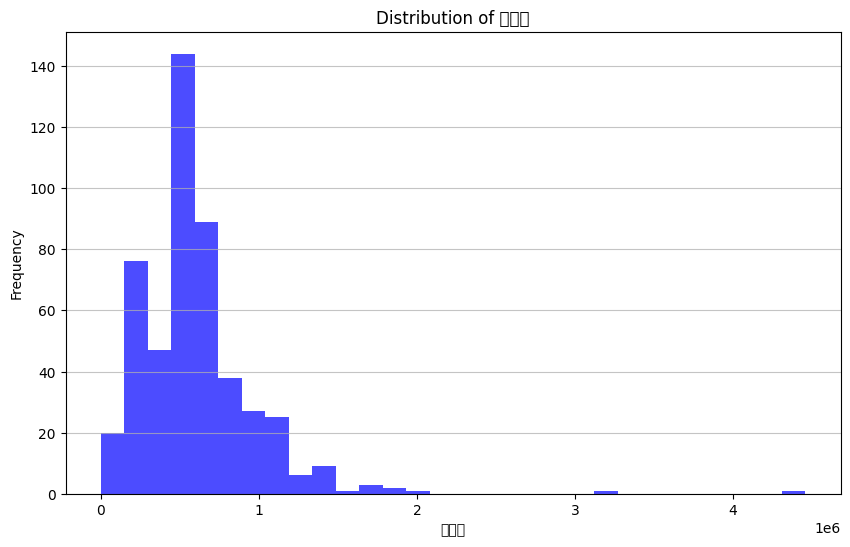

''

In [98]:
prompt = "Please draw the distribution of the column '基本給' in 'df_1', with the title 'Distribution of 基本給'.'"
multiple_file_chain.invoke(prompt)

/Users/formaideveloper/miniconda3/envs/LLM_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 38971 (\N{CJK UNIFIED IDEOGRAPH-983B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/formaideveloper/miniconda3/envs/LLM_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/formaideveloper/miniconda3/envs/LLM_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22522 (\N{CJK UNIFIED IDEOGRAPH-57FA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/formaideveloper/miniconda3/envs/LLM_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/formaideveloper/miniconda

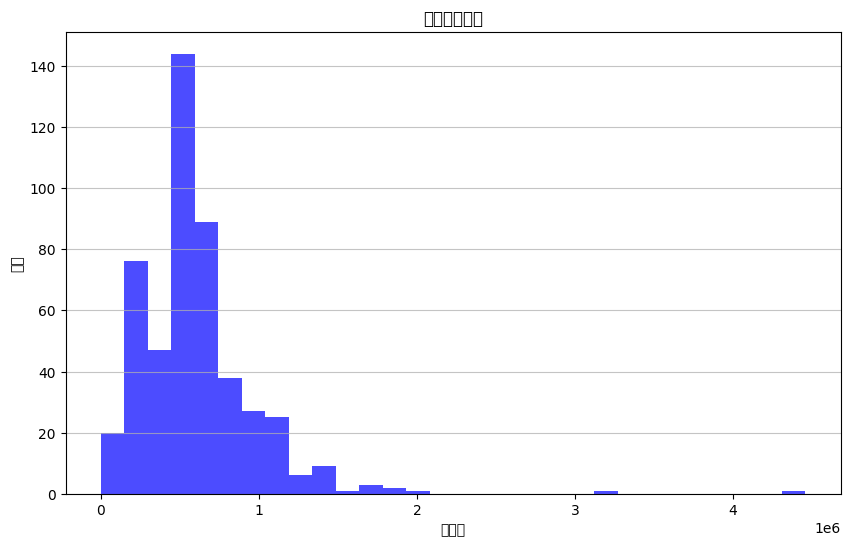

''

In [99]:
prompt = "'df_1'の'基本給'の分布を描画し、タイトルを'基本給の分布'にしてください"
multiple_file_chain.invoke(prompt)

scatter graph

bar graph

pie graph

export graphs

year, month, day

In [66]:
file_list = ["テスト用データ/other_1/calc_data.csv",
             "テスト用データ/other_1/kintai_info.csv",
            "テスト用データ/other_1/timepro_data.csv"]
chain = create_multiple_file_chain_info_version_3(file_list, llm)

Read the file calc_data.csv!
csv_1 : テスト用データ/other_1/calc_data.csv
Read the file kintai_info.csv!
csv_2 : テスト用データ/other_1/kintai_info.csv
Read the file timepro_data.csv!
csv_3 : テスト用データ/other_1/timepro_data.csv


In [23]:
prompt = "データフレームの年月認識と比較: 1. {kintai_info.csv}から'支給日'列、{timepro_data.csv}と{calc_data.csv}から'年月'列をそれぞれ抽出し、これらを年月情報としていろんformatで解析しながら'YYYY-MM'形式で出力してください。 2. {kintai_info}の年月が他の2つのファイルの年月よりも1か月早いか判定してください。"
chain.invoke(prompt)

,kintai_info_年月,calc_data_年月,timepro_data_年月,kintai_early_vs_calc,kintai_early_vs_timepro
0,2024-04-01,2024-03-01,2024-03-01,False,False
1,2024-04-01,2024-03-01,2024-03-01,False,False
2,2024-04-01,2024-03-01,2024-03-01,False,False
3,2024-04-01,2024-03-01,2024-03-01,False,False
4,2024-04-01,2024-03-01,2024-03-01,False,False
...,...,...,...,...,...
485,2024-04-01,NaT,NaT,False,False
486,2024-04-01,NaT,NaT,False,False
487,2024-04-01,NaT,NaT,False,False
488,2024-04-01,NaT,NaT,False,False


In [52]:
prompt = "{kintai_info.csv}から'支給日'列を、{timepro_data.csv}と{calc_data.csv}から'年月'列をそれぞれ抽出し、これらを年月情報としていろんformatで解析しながら'YYYY-MM'形式で出力してください. {kintai_info}の年月が他の2つのファイルの年月よりも1か月早いか判定して, 結果がすべてFalseの場合、Falseを返してください。"
chain.invoke(prompt)

False

In [57]:
prompt =  "1. {kintai_info.csv}から'支給日'列を、{timepro_data.csv}と{calc_data.csv}から'年月'列をそれぞれ抽出し、これらを年月情報としていろんformatで解析しながら'YYYY-MM'形式で出力してください. {kintai_info}の年月が他の2つのファイルの年月よりも1か月早いか判定して, 結果がすべてFalseの場合、処理中断して下さい。\
2. データの抽出と保存: a. {kintai_info.csv}から列を抽出と保存: スタッフコード, 姓, 名, 支給日, 給与規定グループ名. b. {timepro_data.csv}から列を抽出と保存: 社員番号, 出勤日数, 出勤時間, 所定内残業手当, 普通残業手当, 深夜残業手当, 法定外休日残業手当, 法定休日残業手当, 60時間超過手当, 代休控除, 遅刻早退控除, 当月所定勤務時間 c. {calc_data.csv}から{timepro_data.csv}と同じ列を抽出と保存, \
    3. データのマージ: - 2.bと2.cで保存した{timepro_data.csv}と{calc_data.csv}を結合   - 結合したデータと2.aで保存した{kintai_info.csv}を左外部結合（2.aで保存した{kintai_info.csv}を基準, \
        4. 左外部結合のデータの後処理:   - 重複列を削除   - 欠損値を処理   - 日付・時間フォーマットを統一,\
            5. 後処理結果の出力:   - 処理済みデータを'YYYYMM勤怠取込データ_YYYYMMDD.csv'として出力, \
                6. データの整合性チェック:   - マージ後データと元データの各列の合計値を計算\n   - 合計値を比較し、差異を報告"
chain.invoke(prompt)

"SyntaxError: f-string: unmatched '(' (<unknown>, line 43)"

In [72]:
llm = ChatOpenAI(model="gpt-4o-mini", api_key=api_key)
file_list = ["テスト用データ/other_1/calc_data.csv",
             "テスト用データ/other_1/kintai_info.csv",
            "テスト用データ/other_1/timepro_data.csv"]
chain = create_multiple_file_chain_info_version_3(file_list, llm)
prompt =  "1. データの抽出と保存: a. {kintai_info.csv}から列を抽出と保存: スタッフコード, 姓, 名, 支給日, 給与規定グループ名. b. {timepro_data.csv}から列を抽出と保存: 社員番号, 出勤日数, 出勤時間, 所定内残業手当, 普通残業手当, 深夜残業手当, 法定外休日残業手当, 法定休日残業手当, 60時間超過手当, 代休控除, 遅刻早退控除, 当月所定勤務時間 c. {calc_data.csv}から列を抽出と保存:から列を抽出と保存: 社員番号, 出勤日数, 所定内残業手当, 普通残業手当, 深夜残業手当, 法定外休日残業手当, 法定休日残業手当, 60時間超過手当, 代休控除, 遅刻早退控除\
    2. データのマージ、マージする前にデータ型をチェックし、必要であれば単一化する。: - 2.bと2.cで保存した{timepro_data.csv}と{calc_data.csv}を結合   - 結合したデータと2.aで保存した{kintai_info.csv}を左外部結合（2.aで保存した{kintai_info.csv}を基準, \
        3. 左外部結合のデータの後処理:   - 重複列を削除   - 欠損値を処理   - {支給日}を年月情報をいろんformatで解析しながら'YYYY-MM'形式で出力\
            4. 後処理結果の出力:   - 処理済みデータを'YYYYMM勤怠取込データ_YYYYMMDD.csv'として出力"
chain.invoke(prompt)

Read the file calc_data.csv!
csv_1 : テスト用データ/other_1/calc_data.csv
Read the file kintai_info.csv!
csv_2 : テスト用データ/other_1/kintai_info.csv
Read the file timepro_data.csv!
csv_3 : テスト用データ/other_1/timepro_data.csv


<string>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<string>:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a futu

''

In [76]:
llm = ChatOpenAI(model="gpt-4", api_key=api_key)
file_list = ["テスト用データ/other_1/calc_data.csv",
             "テスト用データ/other_1/kintai_info.csv",
            "テスト用データ/other_1/timepro_data.csv"]
chain = create_multiple_file_chain_info_version_3(file_list, llm)
prompt =  "1. データの抽出と保存: a. {kintai_info.csv}から列を抽出と保存: スタッフコード, 姓, 名, 支給日, 給与規定グループ名. b. {timepro_data.csv}から列を抽出と保存: 社員番号, 出勤日数, 出勤時間, 所定内残業手当, 普通残業手当, 深夜残業手当, 法定外休日残業手当, 法定休日残業手当, 60時間超過手当, 代休控除, 遅刻早退控除, 当月所定勤務時間 c. {calc_data.csv}から列を抽出と保存:から列を抽出と保存: 社員番号, 出勤日数, 所定内残業手当, 普通残業手当, 深夜残業手当, 法定外休日残業手当, 法定休日残業手当, 60時間超過手当, 代休控除, 遅刻早退控除\
    2. データのマージ、マージする前にデータ型をチェックし、必要であれば単一化する。: - 2.bと2.cで保存した{timepro_data.csv}と{calc_data.csv}を結合   - 結合したデータと2.aで保存した{kintai_info.csv}を左外部結合（2.aで保存した{kintai_info.csv}を基準, \
        3. 左外部結合のデータの後処理:   - 重複列を削除   - 欠損値を処理   - {支給日}を年月情報をいろんformatで解析しながら'YYYY-MM'形式で出力\
            4. 後処理結果の出力:   - 処理済みデータを'YYYYMM勤怠取込データ_YYYYMMDD_gpt_4.csv'として出力"
chain.invoke(prompt)

Read the file calc_data.csv!
csv_1 : テスト用データ/other_1/calc_data.csv
Read the file kintai_info.csv!
csv_2 : テスト用データ/other_1/kintai_info.csv
Read the file timepro_data.csv!
csv_3 : テスト用データ/other_1/timepro_data.csv


''

In [75]:
llm = ChatOpenAI(model="gpt-4", api_key=api_key)
file_list = ["テスト用データ/other_1/calc_data.csv",
             "テスト用データ/other_1/kintai_info.csv",
            "テスト用データ/other_1/timepro_data.csv"]
chain = create_multiple_file_chain_info_version_3(file_list, llm)
prompt =  "1.{kintai_info.csv}から'支給日'列を、{timepro_data.csv}と{calc_data.csv}から'年月'列をそれぞれ抽出し、これらを年月情報としていろんformatで解析しながら'YYYY-MM'形式で出力してください. {kintai_info}の年月が他の2つのファイルの年月よりも1か月早いか判定して, 結果がすべてFalseの場合、処理中断して下さい。\
    2. データの抽出と保存: a. {kintai_info.csv}から列を抽出と保存: スタッフコード, 姓, 名, 支給日, 給与規定グループ名. b. {timepro_data.csv}から列を抽出と保存: 社員番号, 出勤日数, 出勤時間, 所定内残業手当, 普通残業手当, 深夜残業手当, 法定外休日残業手当, 法定休日残業手当, 60時間超過手当, 代休控除, 遅刻早退控除, 当月所定勤務時間 c. {calc_data.csv}から列を抽出と保存:から列を抽出と保存: 社員番号, 出勤日数, 所定内残業手当, 普通残業手当, 深夜残業手当, 法定外休日残業手当, 法定休日残業手当, 60時間超過手当, 代休控除, 遅刻早退控除\
    3. データのマージ、マージする前にデータ型をチェックし、必要であれば単一化する。: - 2.bと2.cで保存した{timepro_data.csv}と{calc_data.csv}を結合   - 結合したデータと2.aで保存した{kintai_info.csv}を左外部結合（2.aで保存した{kintai_info.csv}を基準, \
        4. 左外部結合のデータの後処理: - 重複列を削除   - 欠損値を処理   - {支給日}を年月情報をいろんformatで解析しながら'YYYY-MM'形式で出力\
            5. 後処理結果の出力: - 処理済みデータを'YYYYMM勤怠取込データ_YYYYMMDD_gpt_4.csv'として出力"
chain.invoke(prompt)

Read the file calc_data.csv!
csv_1 : テスト用データ/other_1/calc_data.csv
Read the file kintai_info.csv!
csv_2 : テスト用データ/other_1/kintai_info.csv
Read the file timepro_data.csv!
csv_3 : テスト用データ/other_1/timepro_data.csv


'ValueError: time data "2024-04-25" doesn\'t match format "%Y%m%d", at position 0. You might want to try:\n    - passing `format` if your strings have a consistent format;\n    - passing `format=\'ISO8601\'` if your strings are all ISO8601 but not necessarily in exactly the same format;\n    - passing `format=\'mixed\'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.'